In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import math
import scipy.special as sps
from scipy.stats import nakagami

## Nakagami Likelihood

In [3]:
omega=1.

In [4]:
h = nakagami.rvs(nu=4., size=10000)

In [5]:
n = len(h)

In [6]:
def negloglikelihood(m):
    return - (len(h) * (m *(np.log(m) - np.log(omega)) - np.log(sps.gamma(m)))
              - m *(np.sum(h ** 2) / omega - 2 * np.sum(np.log(h))))

In [7]:
m = np.linspace(.5, 10., 100)

In [8]:
ll = negloglikelihood(m)

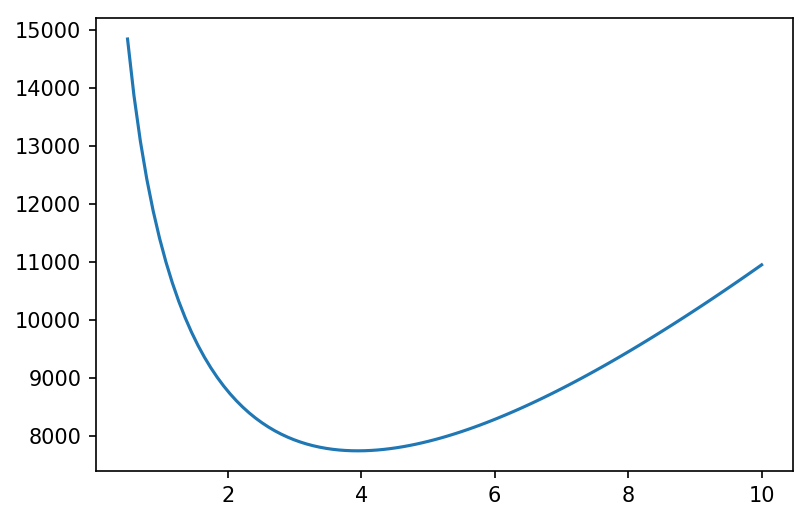

In [9]:
plt.plot(m, ll)

In [31]:
m[np.argmin(ll)]

3.9545454545454541

## Lower bound for $m \log m$

In [10]:
mt = 1.

In [11]:
dmlogm = m * (np.log(mt) + 1) - mt

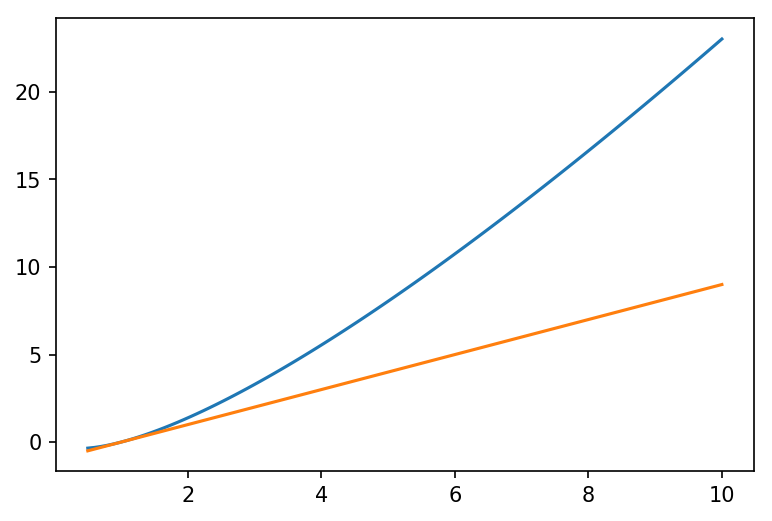

In [12]:
plt.plot(m, m * np.log(m))
plt.plot(m, dmlogm)

## Lower bound for $-\log\Gamma(m)$

In [13]:
f = np.log(sps.gamma(m))

In [14]:
p = sps.polygamma(1, .5)

In [15]:
g = np.log(sps.gamma(mt)) + sps.digamma(mt) * (m - mt) + .5*p * (m - mt) ** 2

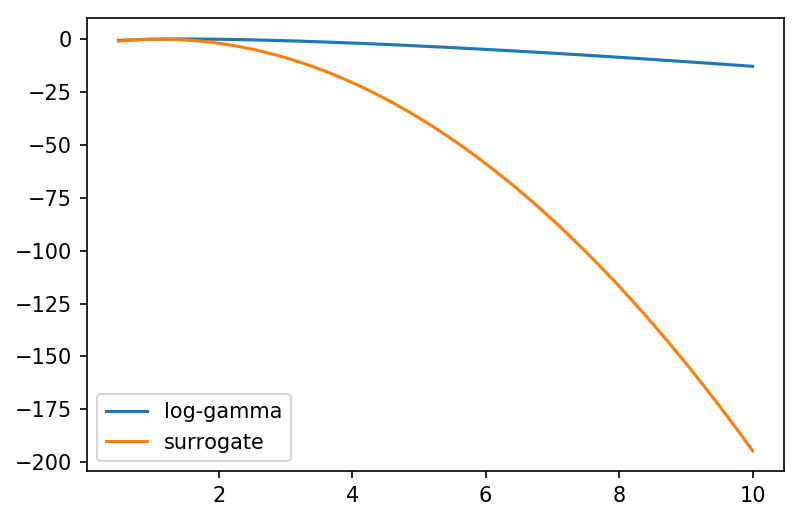

In [16]:
plt.plot(m, -f, label='log-gamma')
plt.plot(m, -g, label='surrogate')
plt.legend()

In [17]:
def surrogate(m, mt):
    return -(len(h) * (m * (np.log(mt) + 1) - mt - m * np.log(omega)
                       - (np.log(sps.gamma(mt)) + sps.digamma(mt) * (m - mt) + .5 * (m - mt) ** 2))
              - m *(np.sum(h ** 2) / omega - 2 * np.sum(np.log(h))))

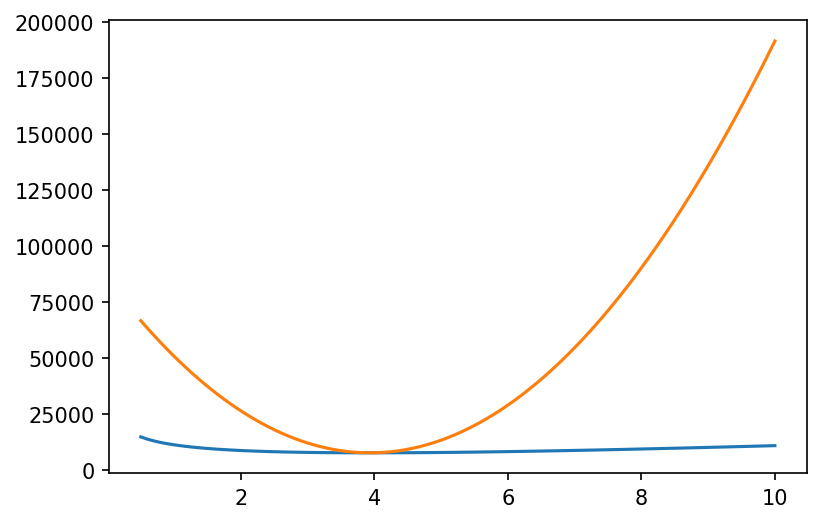

In [22]:
plt.plot(m, ll)
plt.plot(m, surrogate(m, mt))

It's correct!

## Surrogate function minimizer

In [32]:
mt = 1.

In [33]:
i = 0 
while True:
    mt_update = (1 + math.log(mt/omega) - sps.digamma(mt)
                 + p * mt + (2 * np.sum(np.log(h)) - np.sum(h **2) / omega) / n) / p
    if abs(mt - mt_update) < 1e-4:
        break
    mt = mt_update
    i += 1

In [34]:
i

646

In [35]:
mt_update

3.9350877097050181